In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from skimage import io
from skimage.filters import gaussian

import time
import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
from scipy.ndimage import uniform_filter, zoom
import hyperspy.api as hs
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, clear_output

In [11]:
class CVAE3D(nn.Module):
    """Convolutional variational autoencoder for 50x50x250 input with stride 1."""

    def __init__(self, latent_dim):
        super(CVAE3D, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x50x50x250
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x50x50x250
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2)),  # Output: 64x25x25x125
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: 128x25x25x125
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: 256x25x25x125
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,1,5), stride=(1,1,5)),  # Output: 256x25x25x25
            nn.Flatten(),
            nn.Linear(256 * 25 * 25 * 25, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 25 * 25 * 25),
            nn.ReLU(),
            nn.Unflatten(1, (256, 25, 25, 25)),
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1),  # Output: 128x25x25x25
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x25x25x25
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2,5), mode='nearest'),  # Output: 64x50x50x125
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x50x50x125
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1, padding=1),  # Output: 16x50x50x125
            nn.ReLU(),
            nn.Upsample(scale_factor=(1,1,2), mode='nearest'),  # Output: 16x50x50x250
            nn.ConvTranspose3d(16, 1, kernel_size=3, stride=1, padding=1),  # Output: 1x50x50x250
            nn.Sigmoid()  # Ensure output is in [0, 1] range
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar
            
#! kernel of 5 and stride of 1, another layer, confirm there is no compression in the energy direction. 

############################################################################################################
##################################### END OF MODEL DEFINITION ##############################################
############################################################################################################

def load_dm4_data(filepath):
    s = hs.load(filepath)
    data = s.data  # The 3D data array
    return data

def preprocess_3d_images(image, target_size, sigma, energy_range, xy_window):

    """
    Preprocess 3D images with arbitrary input and output dimensions.
    
    :param image: Input 3D image (height, width, depth)
    :param target_size: Tuple of (height, width, depth) for the target size
    :param sigma: Sigma for Gaussian blur
    :param energy_range: Tuple of (min_energy, max_energy) in eV
    :param xy_window: Window size for spatial-spectral smoothing
    :return: Tuple of (preprocessed_image, reshaped_image)
    """
    # Apply Gaussian blur
    blurred_image = gaussian(image, sigma=sigma, mode='reflect', preserve_range=True)
    
    # Calculate the pixel indices corresponding to the energy range
    start_pixel = int(energy_range[0])
    end_pixel = int(energy_range[1])
    
    # Slice the data array to keep only the desired energy range in the depth dimension
    blurred_image = blurred_image[:, :, start_pixel:end_pixel]
    
    # Normalize the image
    normalized_image = blurred_image / np.max(blurred_image)
    
    # Apply spatial-spectral smoothing
    def smooth_spatial_spectral(arr, window):
        neighborhood_sum = uniform_filter(arr, size=(window, window, 1), mode='reflect')
        neighborhood_count = uniform_filter(np.ones_like(arr), size=(window, window, 1), mode='reflect')
        return neighborhood_sum / neighborhood_count
    
    smoothed_img = smooth_spatial_spectral(normalized_image, xy_window)
    
    # Resize the image to match the target size
    current_size = smoothed_img.shape
    scale_factors = [t / c for t, c in zip(target_size, current_size)]
    
    resized_img = zoom(smoothed_img, scale_factors, order=1)  # order=1 for linear interpolation
    
    # Ensure the final shape matches the target size
    assert resized_img.shape == target_size, f"Shape mismatch: {resized_img.shape} != {target_size}"
    
    # Reshape to (1, 1, height, width, depth) for PyTorch
    reshaped_image = resized_img.reshape((1, 1, *target_size))
    
    return resized_img, reshaped_image.astype('float32')

############################################################################################################
##################################### END OF DATA PREPROCESSING ############################################
############################################################################################################
    
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = F.binary_cross_entropy_with_logits(x_logit, x, reduction='sum')
    logpx_z = -cross_ent
    logpz = log_normal_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z + logpz - logqz_x)

def log_normal_pdf(sample, mean, logvar):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(-0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), dim=1)

def gaussian_blur(img, sigma):
    return np.array(gaussian(img, (sigma, sigma)))

def gaussian_blur_arr(images, sigma):
    return np.array([gaussian_blur(img, sigma) for img in images])

def norm_max_pixel(images):
    return np.array([img / np.max(img) for img in images])

def visualize_inference(model, input_image, data, energy_range, x=0, y=0):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_image).unsqueeze(0).to(next(model.parameters()).device)
        mean, logvar = model.encode(input_tensor)
        z = model.reparameterize(mean, logvar)
        prediction = model.decode(z, apply_sigmoid=True)

    # Set the pixel manually
    selected_pixel = (y, x)

    # Create two separate figures
    fig_images = make_subplots(rows=1, cols=2, subplot_titles=('Input Image', 'Prediction'))
    fig_spectra = make_subplots(rows=1, cols=2, subplot_titles=('Input Spectral Graph', 'Predicted Spectral Graph'))

    # Input Image
    middle_slice_input = input_image[0, :, :, input_image.shape[3] // 2].cpu().numpy()
    fig_images.add_trace(go.Heatmap(z=middle_slice_input, colorscale='Viridis', showscale=False), row=1, col=1)
    fig_images.add_trace(go.Scatter(x=[selected_pixel[1]], y=[selected_pixel[0]], mode='markers', 
                                    marker=dict(color='red', size=10), showlegend=False), row=1, col=1)

    # Prediction
    middle_slice_prediction = prediction[0, 0, :, :, prediction.shape[4] // 2].cpu().numpy()
    fig_images.add_trace(go.Heatmap(z=middle_slice_prediction, colorscale='Viridis', showscale=False), row=1, col=2)
    fig_images.add_trace(go.Scatter(x=[selected_pixel[1]], y=[selected_pixel[0]], mode='markers', 
                                    marker=dict(color='red', size=10), showlegend=False), row=1, col=2)

    # Update layout to ensure images are not distorted
    fig_images.update_layout(
        height=600,
        width=1200,
        margin=dict(l=20, r=20, t=40, b=20),
        yaxis=dict(scaleanchor="x", scaleratio=1),
        yaxis2=dict(scaleanchor="x2", scaleratio=1)
    )

    # Input Spectral Graph
    input_spectrum = data[selected_pixel[0], selected_pixel[1], :]
    x_energy = np.linspace(energy_range[0], energy_range[1], input_spectrum.shape[0])
    fig_spectra.add_trace(go.Scatter(x=x_energy, y=input_spectrum), row=1, col=1)

    # Predicted Spectral Graph
    predicted_spectrum = prediction[0, 0, selected_pixel[0], selected_pixel[1], :].cpu().numpy()
    fig_spectra.add_trace(go.Scatter(x=x_energy, y=predicted_spectrum), row=1, col=2)

    fig_spectra.update_layout(
        height=500,
        width=1200,
        margin=dict(l=20, r=20, t=40, b=20)
    )
    
    return fig_images, fig_spectra

def create_loss_plot():
    """Create an empty Plotly figure for the loss plot."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[], y=[], mode='lines', name='Training Loss'))
    fig.update_layout(title='Training Loss',
                      xaxis_title='Epoch',
                      yaxis_title='Loss',
                      height=400,
                      width=800)
    return fig

def spectra(data, energy_range):     
    '''Function to plot the spectra of the data''' 
    plt.plot(data[:3, :3, :].mean(axis = (0, 1)))
    
    # Calculate the pixel indices corresponding to the energy range
    start_pixel = int((energy_range[0] - 0))
    end_pixel = int((energy_range[1] - 0))

    # Slice the data array to keep only the desired energy range in the third dimension
    data = data[:, :, start_pixel:end_pixel]

    # show the shape of the data 
    print(data.shape)

    # show the shape of the data 
    plt.plot(data[:3, :3, :].mean(axis = (0, 1)))
    plt.show()


(51, 50, 250)


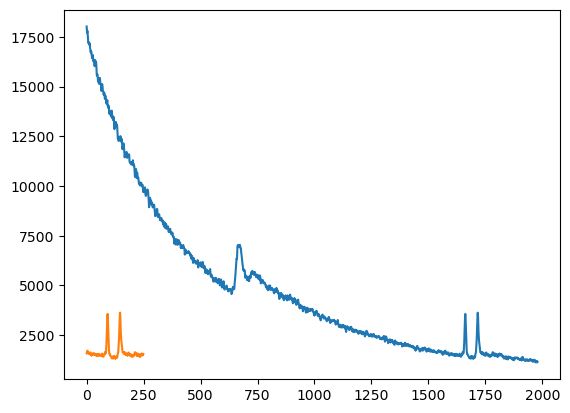

In [12]:
SIZE = 48
SIGMA = 2
epochs = 2000
latent_dim = 128
energy_range = (1570, 1820)  # eV
ev_per_pixel = 0.05
dm4_file = 'data/images_3D/EELS HL SI.dm4'
target_size = (50, 50, energy_range[1]-energy_range[0])  # (x, y, z)

# Load the data with the specified energy range and resolution
data = load_dm4_data(dm4_file)

spectra(data, energy_range)

#! APPLY 2D Smoothing before feeding to the model 
#! generate the image where every pixel ( spectrum ) is the average of 3 by 3 pixels, also try training only on the "white part"
#! try to overtrain by making it bigger if nothing else works 

In [13]:
train_image_viz, train_image = preprocess_3d_images(data, target_size, SIGMA, energy_range, 3)

print(train_image.shape) 

# Create data loaders
train_dataset = TensorDataset(torch.tensor(train_image))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE3D(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Pick a sample of the test set for generating output images
num_examples_to_generate = 1
test_sample = next(iter(train_loader))[0][:num_examples_to_generate].to(device)

(1, 1, 50, 50, 250)


In [14]:
try: 
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)  # Access the first element of the batch
            
            optimizer.zero_grad()
            
            x_recon, mean, logvar = model(x)
            
            # Compute loss (using MSE and KL divergence)
            recon_loss = F.mse_loss(x_recon, x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Create new inference visualizations
            fig_images, fig_spectra = visualize_inference(model, test_sample[0], train_image_viz, energy_range, 24, 24) 

            # Display updated plots
            clear_output(wait=True)
            fig_images.show()
            fig_spectra.show()

            print(f'Epoch: {epoch}, Test set ELBO: {loss:.4f}')
        
except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")

Epoch: 293, Test set ELBO: 184.8504
Training interrupted. Saving the model...


In [ ]:
# Create new inference visualizations
fig_images, fig_spectra = visualize_inference(model, test_sample[0], train_image_viz, energy_range, 24, 20)

# Display updated plots
fig_images.show()
fig_spectra.show()

In [ ]:
torch.save(model.state_dict(), 'cvae3d_50_50_250.pth')